# Predicting Failure Probability of PC7000 Excavator

This notebook demonstrates a machine learning experiment to predict the probability of failure for a PC7000 excavator using a synthetic dataset. We will generate synthetic data, visualize it, preprocess, train a classification model, evaluate its performance, and make probability predictions for new data.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [2]:
# Generate Synthetic PC7000 Excavator Data
np.random.seed(42)
n_samples = 1000
operating_hours = np.random.uniform(1000, 20000, n_samples)
load = np.random.uniform(0.5, 1.5, n_samples)
avg_temp = np.random.uniform(20, 80, n_samples)
vibration = np.random.uniform(0.1, 2.0, n_samples)
maintenance_count = np.random.randint(0, 10, n_samples)

# Synthetic formula for failure probability
failure_score = (
    0.00008 * operating_hours +
    0.5 * (load - 1.0) +
    0.02 * (avg_temp - 50) +
    0.3 * (vibration - 1.0) +
    0.1 * maintenance_count +
    np.random.normal(0, 0.2, n_samples)
)
failure_prob = 1 / (1 + np.exp(-failure_score))

# Binary label: 1 = failure, 0 = normal
failure_label = (failure_prob > 0.5).astype(int)

# Create DataFrame
data = pd.DataFrame({
    'OperatingHours': operating_hours,
    'Load': load,
    'AvgTemp': avg_temp,
    'Vibration': vibration,
    'MaintenanceCount': maintenance_count,
    'FailureProb': failure_prob,
    'Failure': failure_label
})
data.head()

,OperatingHours,Load,AvgTemp,Vibration,MaintenanceCount,FailureProb,Failure
0,8116.262258,0.685133,35.702341,1.378136,9,0.788575,1
1,19063.571822,1.041901,34.818728,1.613695,4,0.849790,1
2,14907.884894,1.372946,74.375275,0.575889,4,0.878514,1
3,12374.511200,1.232225,34.972772,1.287261,6,0.818872,1
4,3964.354168,1.306561,36.316984,1.186317,3,0.625294,1


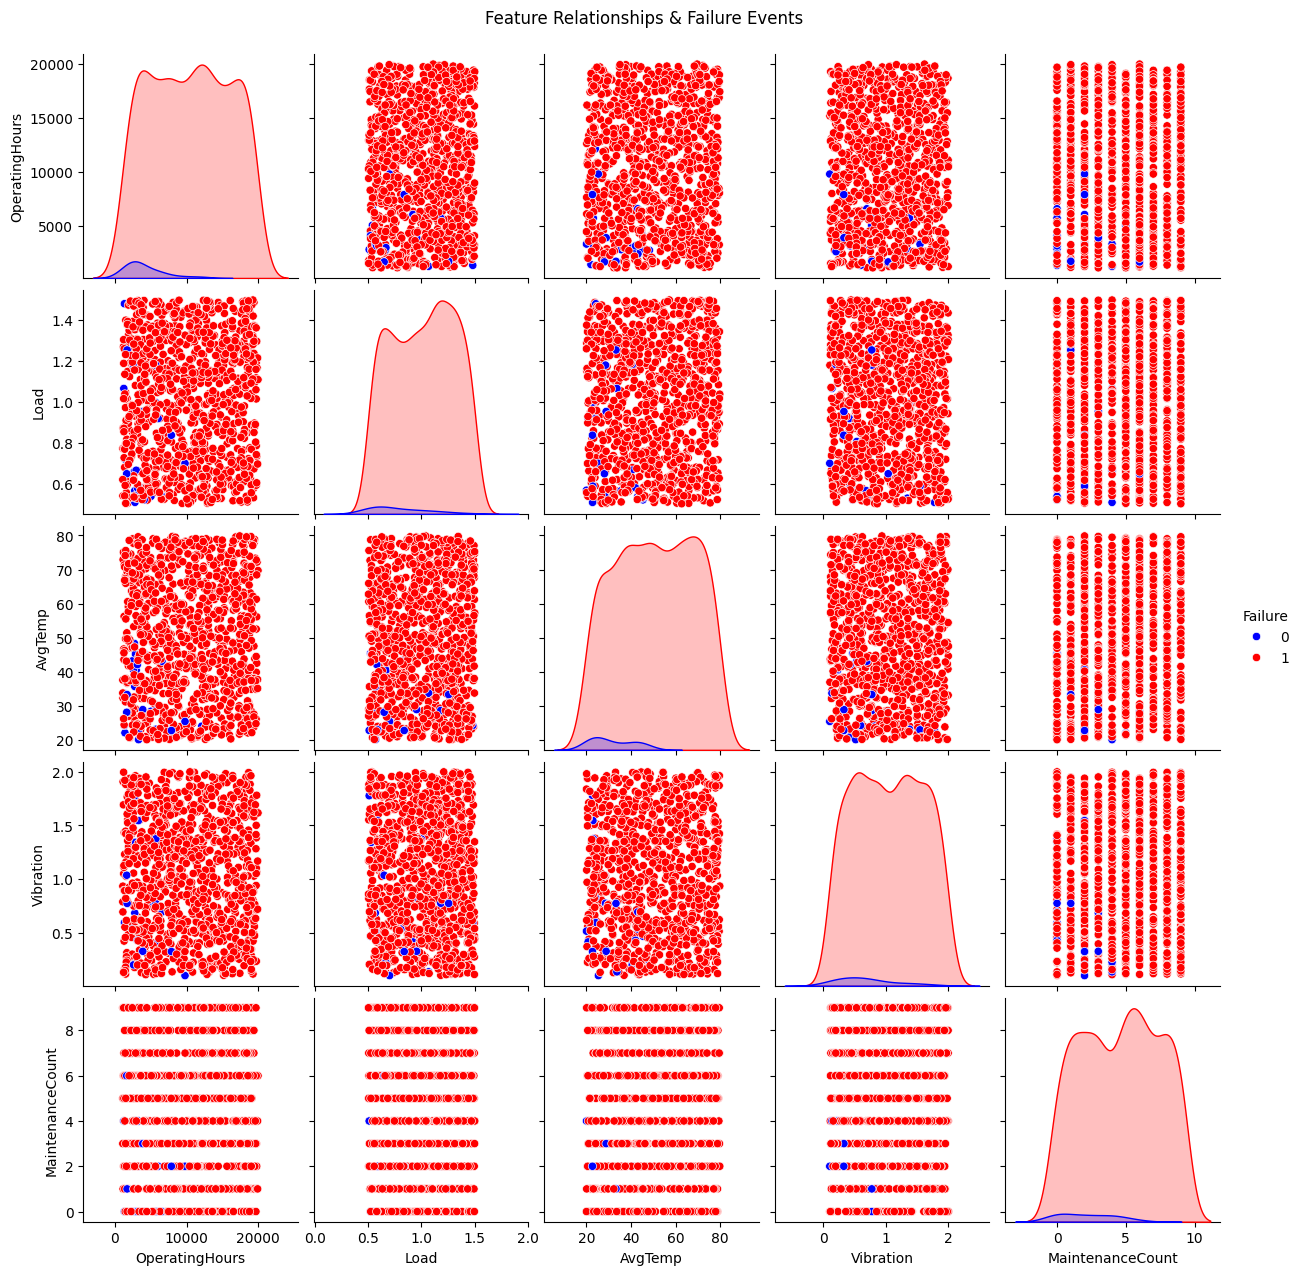

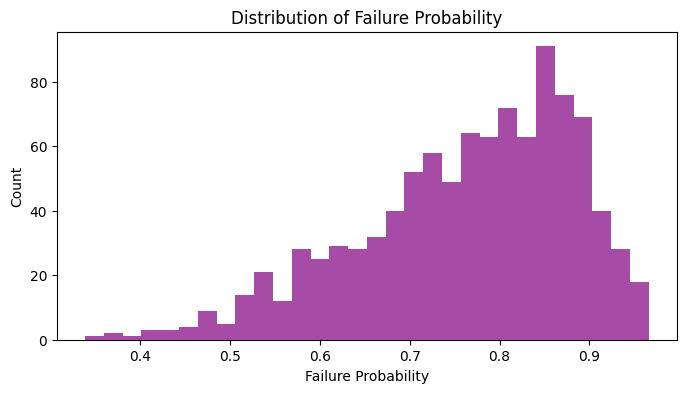

In [3]:
# Visualize Data Distributions
sns.pairplot(data, vars=['OperatingHours', 'Load', 'AvgTemp', 'Vibration', 'MaintenanceCount'], hue='Failure', palette={0: 'blue', 1: 'red'})
plt.suptitle('Feature Relationships & Failure Events', y=1.02)
plt.show()

plt.figure(figsize=(8,4))
plt.hist(data['FailureProb'], bins=30, color='purple', alpha=0.7)
plt.xlabel('Failure Probability')
plt.ylabel('Count')
plt.title('Distribution of Failure Probability')
plt.show()

In [4]:
# Preprocess Data (Scaling & Cleaning)
features = ['OperatingHours', 'Load', 'AvgTemp', 'Vibration', 'MaintenanceCount']
print('Missing values per column:')
print(data[features].isnull().sum())

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

Missing values per column:
OperatingHours      0
Load                0
AvgTemp             0
Vibration           0
MaintenanceCount    0
dtype: int64


In [5]:
# Train-Test Split
X = data[features]
y = data['Failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

Training samples: 800, Testing samples: 200


In [6]:
# Train Failure Probability Model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print('Model training complete.')

Model training complete.


Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         7
     Failure       0.96      1.00      0.98       193

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.93      0.96      0.95       200

ROC AUC: 0.92


/home/brandon/.dev/repos/ml-experiments/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/brandon/.dev/repos/ml-experiments/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/brandon/.dev/repos/ml-experiments/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

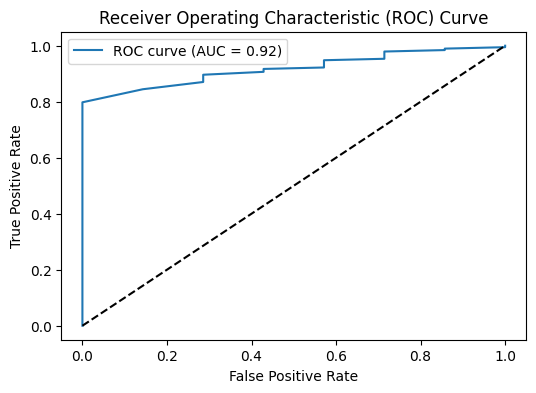

In [7]:
# Evaluate Model Performance
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Failure']))
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [8]:
# Predict Failure Probability for New Data Examples
new_data = pd.DataFrame({
    'OperatingHours': [5000, 22000],
    'Load': [1.0, 2.5],
    'AvgTemp': [40, 110],
    'Vibration': [0.5, 3.5],
    'MaintenanceCount': [2, 18]
})
new_data[features] = scaler.transform(new_data[features])
proba_new = model.predict_proba(new_data[features])[:, 1]
for i, prob in enumerate(proba_new):
    print(f'Example {i+1}: Predicted Failure Probability = {prob:.2f}')

Example 1: Predicted Failure Probability = 0.94
Example 2: Predicted Failure Probability = 1.00
